In [36]:
import copy

import torch
%cd /home/ltchen/gnnpp
from utils.data import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from utils.plot import plot_map


/home/ltchen/gnnpp


## a) Scatterplot of actual stations (altitude) without edges

In [8]:
df = load_dataframes(mode="train", leadtime="24h")
stations = df["stations"]
print(stations.columns)

[INFO] Dataframes exist. Will load pandas dataframes.
Index(['station_id', 'lat', 'lon', 'altitude', 'name'], dtype='object')


0       4.781000
1       4.790000
2       4.921000
3       5.346000
4       5.180000
         ...    
117     3.149333
118     9.746111
119     9.600000
120    10.186111
121    10.185555
Name: lon, Length: 122, dtype: float64


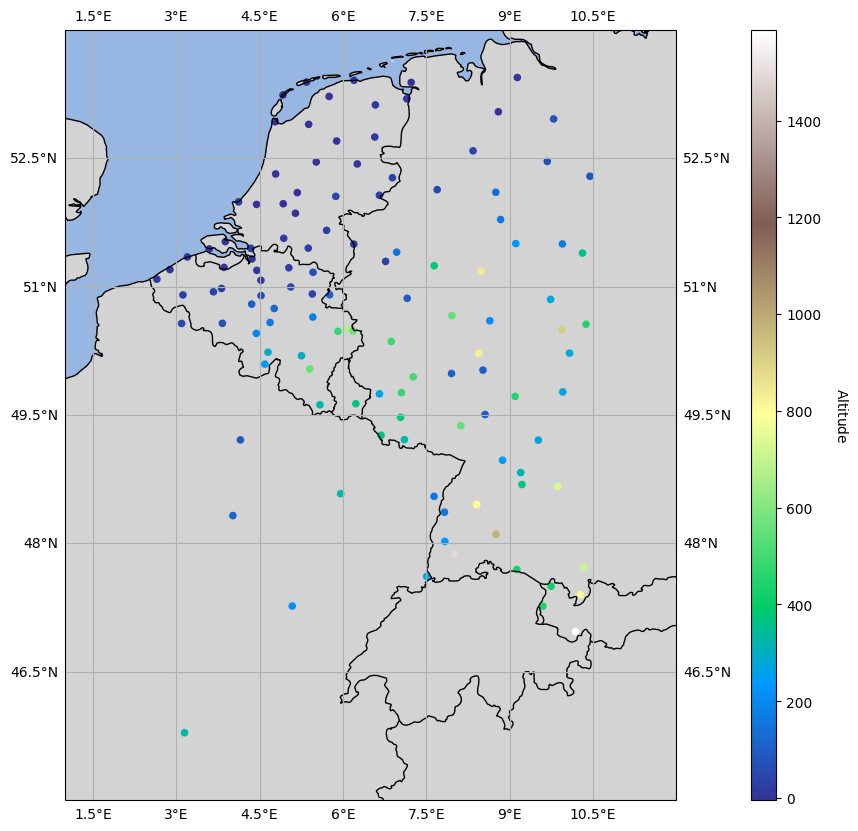

In [172]:
%matplotlib inline

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_extent([1, 12, 45, 54], crs=proj)
ax.add_feature(cfeature.LAND, color="lightgrey")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)

plot = ax.scatter(stations['lon'], stations['lat'], c=stations['altitude'], cmap='terrain', s=20, transform=proj)

norm = plt.Normalize(vmin=min(stations.altitude), vmax=max(stations.altitude))
sm_nodes = plt.cm.ScalarMappable(cmap="terrain", norm=norm)
colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.08)
colbar.ax.set_ylabel(r'$\mathrm{Altitude}$', rotation=270, labelpad=20)

ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax.set_rasterized(True)

## Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))

print(stations['lon'])

#plt.savefig("figures/stations.pdf", format="pdf", bbox_inches="tight", dpi=300)

## Overview Graph data

In [31]:
# d besteht aus edge_index,
dist = load_distances(df["stations"])
max_dist = 100

#graphs_train_rf, tests = normalize_features_and_create_graphs(
#    training_data=df["train"],
#    valid_test_data=[df["test_rf"], df["test_f"]],
#    mat=dist,
#    max_dist=max_dist,
#)
graph = create_multigraph(df["train"][0], df["train"][1], distances=dist, max_dist=max_dist)


[INFO] Computing distances...


In [238]:
# what exactly is graph?
print(type(graph))
print(type(graph[0]))
print(len(graph)) # graph consists of forecasts of every date (3448 days in rf 24h)
print(graph[0].x[:, 0]) # 0, 1, ..., 121, 0, 1, ..., 121, 0, ... 121 # wie saehe x mit summary statistics aus?
print(graph[0].x[:, 5].shape) # lat
print(graph[0].x[:, 6]) # lon
print(graph[0].x.shape) # why do we have 34 features instead of 36? which 2 were dropped? => (no time, no number)
print(graph[0].num_nodes)
print(graph[0].edge_index.shape)

e_idx = np.array(graph[0].x[:, 0])[graph[0].edge_index]
print(e_idx.shape)

print(graph[0].keys())

print(graph[0].n_idx)
# pos sollte gleiche shape haben wie x, nur mit 2 statt 34


<class 'list'>
<class 'torch_geometric.data.data.Data'>
3448
tensor([  0.,   1.,   2.,  ..., 119., 120., 121.])
torch.Size([1342])
tensor([ 4.7810,  4.7900,  4.9210,  ...,  9.6000, 10.1861, 10.1856])
torch.Size([1342, 34])
1342
torch.Size([2, 29040])
(2, 29040)
['n_idx', 'edge_attr', 'x', 'y', 'timestamp', 'edge_index']
tensor([  0,   1,   2,  ..., 119, 120, 121])


In [235]:
for i in range(0, graph[0].num_nodes, 122):
    print(graph[0].x[i, 0])
    print(graph[0].x[i, 5])

tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)
tensor(0.)
tensor(52.9280)


## b) Graph color-coded by node degree (no edges)

In [185]:
# add the attribute pos to graph
import copy
d_graph = copy.deepcopy(graph[0])
pos = torch.cat((graph[0].x[:, 6].unsqueeze(0), graph[0].x[:, 5].unsqueeze(0)), dim=0)
d_graph.pos = torch.transpose(pos, 0, 1)
print(d_graph.pos)
d = d_graph

tensor([[ 4.7810, 52.9280],
        [ 4.7900, 52.3180],
        [ 4.9210, 53.2410],
        ...,
        [ 9.6000, 47.2667],
        [10.1861, 47.2558],
        [10.1856, 46.9681]])


In [196]:
# from plot: visualize_graph
plt.style.use("default")
if d.is_directed():
    G = nx.DiGraph()
else:
    G = nx.Graph()

edge_index, dist = d.edge_index.cpu().numpy(), d.edge_attr.cpu().numpy()  # Was distances before

# NOTE: edge_index_att holds the Edges of the new graph,
# however they are labeled consecutively instead of the ordering from stations DataFrame
station_ids = np.array(d.x[:, 0])
edge_index = station_ids[edge_index]  # now the same indexes as in the stations Dataframe are used

# Add nodes (stations) to the graph
for i in range(d.num_nodes): # (1342) all ensemble members per node
    G.add_node(int(d.x[i, 0]), lon=float(d.pos[i, 0]), lat=float(d.pos[i, 1]))  # Add station with ID, LAT and LON

pos = {node: (data["lon"], data["lat"]) for node, data in G.nodes(data=True)}  # Create a positions dict
#print(pos)


In [197]:
# Add edges with edge_length as an attribute
if d.is_directed():
    for edge, a in zip(edge_index.T.tolist(), dist.flatten().tolist()):  # Add all edges
        G.add_edge(edge[0], edge[1], length=a)  # Add all Edges with distance Attribute
else:
    for edge, a in zip(edge_index.T.tolist(), dist.flatten().tolist()):
        if not (G.has_edge(edge[0], edge[1]) or G.has_edge(edge[1], edge[0])):  # Edge only needs to be added once
            G.add_edge(edge[0], edge[1], length=a)  # Add all Edges with distance Attribute

In [201]:
# edge attributes
for a, b, attr in G.edges(data=True):
    print(a, b)
    print(attr["length"])

0 1.0
0.6801126003265381
0 2.0
0.36142289638519287
0 3.0
0.6411069631576538
0 4.0
0.9621768593788147
0 5.0
0.4077899754047394
0 6.0
0.7246875762939453
0 7.0
0.7307505011558533
0 8.0
0.7887299060821533
0 0.0
0.009999999776482582
1 4.0
0.36111563444137573
1 5.0
0.7620143294334412
1 6.0
0.5218279361724854
1 8.0
0.8614223599433899
1 9.0
0.7974811792373657
1 20.0
0.5847055912017822
1 22.0
0.46136534214019775
1 23.0
0.3990074098110199
1 24.0
0.8443156480789185
1 25.0
0.5670899152755737
1 27.0
0.9684945940971375
1 1.0
0.009999999776482582
2 3.0
0.3299652636051178
2 5.0
0.4928845167160034
2 6.0
0.9620663523674011
2 7.0
0.5562768578529358
2 8.0
0.8851079940795898
2 10.0
0.8750550150871277
2 2.0
0.009999999776482582
3 5.0
0.5513949990272522
3 7.0
0.32955899834632874
3 8.0
0.8501571416854858
3 10.0
0.5695568323135376
3 13.0
0.880271315574646
3 3.0
0.009999999776482582
4 5.0
0.9004278779029846
4 6.0
0.461885005235672
4 8.0
0.8276457786560059
4 9.0
0.4785272479057312
4 11.0
0.8271066546440125
4 20.

In [225]:
# degrees
print(len(G.degree))
print(G.degree[0]) # node 0 has degree 10
print(G.degree) # mapping of node to degree

122
10
[(0, 10), (1, 14), (2, 9), (3, 9), (4, 19), (5, 15), (6, 18), (7, 13), (8, 17), (9, 18), (10, 11), (11, 14), (12, 14), (13, 12), (14, 13), (15, 7), (16, 12), (17, 20), (18, 26), (19, 22), (20, 15), (21, 27), (22, 20), (23, 18), (24, 27), (25, 22), (26, 23), (27, 22), (28, 25), (29, 18), (30, 10), (31, 5), (32, 6), (33, 4), (34, 11), (35, 7), (36, 12), (37, 10), (38, 9), (39, 10), (40, 8), (41, 10), (42, 14), (43, 9), (44, 7), (45, 9), (46, 8), (47, 10), (48, 9), (49, 8), (50, 7), (51, 10), (52, 11), (53, 13), (54, 9), (55, 8), (56, 6), (57, 9), (58, 8), (59, 11), (60, 7), (61, 12), (62, 11), (63, 14), (64, 8), (65, 9), (66, 10), (67, 7), (68, 6), (69, 6), (70, 11), (71, 8), (72, 11), (73, 15), (74, 8), (75, 7), (76, 14), (77, 7), (78, 6), (79, 15), (80, 10), (81, 11), (82, 12), (83, 16), (84, 17), (85, 22), (86, 21), (87, 23), (88, 28), (89, 28), (90, 28), (91, 22), (92, 30), (93, 28), (94, 13), (95, 17), (96, 28), (97, 26), (98, 27), (99, 30), (100, 19), (101, 17), (102, 26), (

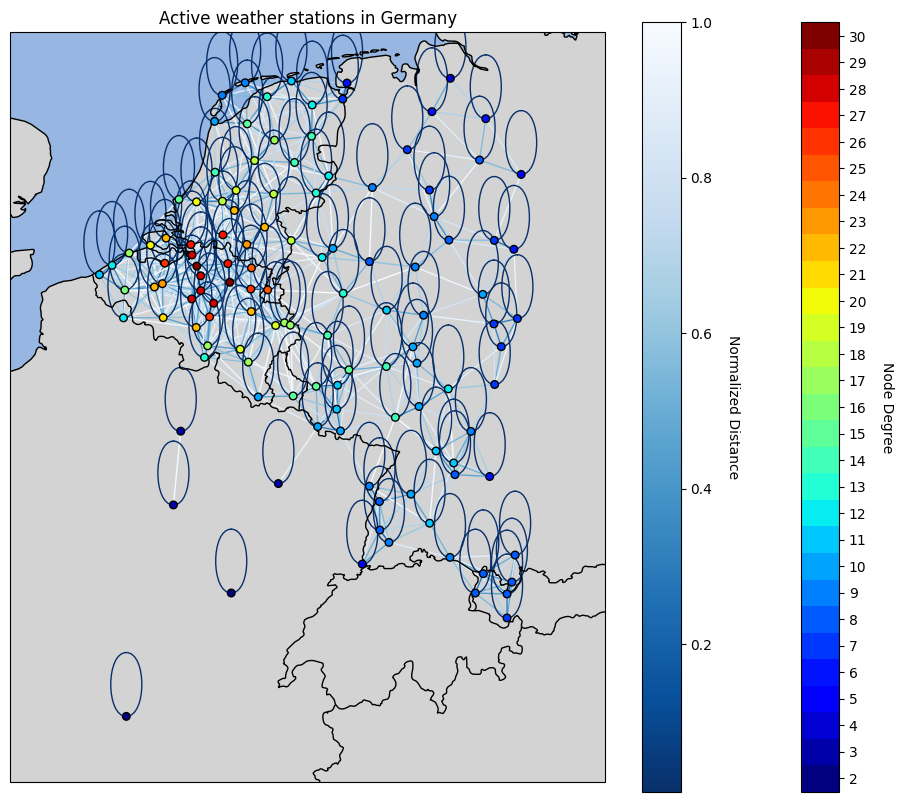

In [236]:
# Edge Colors
color_values = [attr["length"] for _, _, attr in G.edges(data=True)]
cmap = mpl.colormaps.get_cmap("Blues_r")
# Normalize the values to range between 0 and 1
norm = plt.Normalize(min(color_values), max(color_values))
# Generate a list of colors based on the normalized values
colors = [cmap(norm(value)) for value in color_values]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Colors
degrees = G.degree if d.is_undirected() else G.in_degree

node_colors = [deg for _, deg in degrees]
cmap_nodes = plt.get_cmap("jet", max(node_colors) - min(node_colors) + 1)
norm = plt.Normalize(min(node_colors), max(node_colors))
colors_n = [cmap_nodes(norm(value)) for value in node_colors]
sm_nodes = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=norm)

# Plot map (ax = plot_map())
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_extent([1, 12, 45, 54], crs=proj)
ax.add_feature(cfeature.LAND, color="lightgrey")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)

# Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))

ax.set_title("Active weather stations in Germany")

# Colorbar Node degrees

if not all(node_colors[0] == col for col in node_colors[1:]):  # only add colorbar if there are different degrees
    colorbar = plt.colorbar(sm_nodes, ax=ax)
    ticks_pos = (
        np.linspace(
            min(node_colors) + 1,
            max(node_colors),
            max(node_colors) - min(node_colors) + 1,
        )
        - 0.5
    )
    colorbar.set_ticks(ticks_pos)
    ticks = np.arange(min(node_colors), max(node_colors) + 1)
    colorbar.set_ticklabels(ticks)
    colorbar.ax.set_ylabel(f'Node{"_in" if d.is_directed() else ""} Degree', rotation=270, labelpad=20)

# Colormap for Edges
colorbar_e = plt.colorbar(sm, ax=ax)
colorbar_e.ax.set_ylabel("Normalized Distance", rotation=270, labelpad=20)

# Plot Graph
nx.draw_networkx(
    G,
    pos=pos,
    node_size=30,
    node_color=colors_n,
    ax=ax,
    with_labels=False,
    edge_color=colors,
    edgecolors="black",
)

#plt.savefig("stations.eps", format="eps")
plt.show()

# can we remove the self-loops?

## c) Graph b) plus edges color coded by distances (see Moritz BA)

In [ ]:
# c) graph b) plus distances color coded (see Moritz BA)